# Cross-validation

In the [previous section](train_test.ipynb), we have seen that, to obtain unbiased estimates of the predictive performance of any model, it should be evaluated on data that the model has not seen before (during training).

At this point, we often have to make a compromise: the larger the training sample the better our model might get, but - at the same time - we must hold out enough data to hev robust estimates of predictive performance.

A data acquisition in biomedical research is usually costly (both financially and in terms of effort), holding out a significant part of the data solely for testing sounds pretty uneconomical.

Cross-validation is a framework for using as much of the data for training as possible and, at the same time, get as reliable performance estimates of our model (and similar models) as possible.

Yes, with cross-validation you can have your cake and eat it too! But of course only with some extra assumptions.

## The cross-validation scheme

The central idea behind cross-validation is that you create multiple models each oif them using different parts of the data as train and test sets.

The assumption is that all of these models approximate our "idealistic" model (e.g. that we would get when trained on a reasonably large dataset) to a sufficient degree, i.e. they can be considered to constitute a narrow family of tha aforementioned idealistic model.

With this assumptions, we can allows the single models to use as much data for training as possible (by have a relatively large training set small test set).
We don't have to be worried that the single models have too small test sets for robust inference of predictive performance.
We can simply pool and summarize the prediction accuracy estimates of all these models.

Importantly, such pooled estimates will not be specific for any of the models but rather characterise the whole family of models.
In most cases, however, it is perfectly fine to be able to draw a conclusion about the predictive performance of "models similar to this", instead of "this" very specific model.



## Leave-one-out cross-validation

The simplest form of cross validation is leave-one-out (LOO) cross-validation.
As illustrated on the figure {numref}`loo`, in LOO, we have as many models as many subjects(/participants/examples/rows) our dataset has and all of these models leave out a different single subject for testing purposes.

:::{figure-md} loo
<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/LOOCV.gif" alt="fishy" width="400px">

Leave-one-out cross-validation *(Source: [Wikipedia](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#/media/File:LOOCV.gif), user: MBanuelos22, unmodified, CC BY-SA 4.0)*.
:::

LOO is very simple to implement in python with a single for loop:

In [7]:
import numpy as np

subjects = np.array(['a', 'b', 'c', 'd', 'e', 'f'])
num_subjects = len(subjects)
indices = np.arange(num_subjects)

for i in indices:
    print("LOO iteration", i, ": Here is model", i, "to be fitted and tested on:")
    print("\tTrain indices:", indices[indices!=i],  "Test index:", indices[indices==i])
    print("\tTrain data   :", subjects[indices!=i],  "Test data :", subjects[indices==i])


LOO iteration 0 : Here is model 0 to be fitted and tested on:
	Train indices: [1 2 3 4 5] Test index: [0]
	Train data   : ['b' 'c' 'd' 'e' 'f'] Test data : ['a']
LOO iteration 1 : Here is model 1 to be fitted and tested on:
	Train indices: [0 2 3 4 5] Test index: [1]
	Train data   : ['a' 'c' 'd' 'e' 'f'] Test data : ['b']
LOO iteration 2 : Here is model 2 to be fitted and tested on:
	Train indices: [0 1 3 4 5] Test index: [2]
	Train data   : ['a' 'b' 'd' 'e' 'f'] Test data : ['c']
LOO iteration 3 : Here is model 3 to be fitted and tested on:
	Train indices: [0 1 2 4 5] Test index: [3]
	Train data   : ['a' 'b' 'c' 'e' 'f'] Test data : ['d']
LOO iteration 4 : Here is model 4 to be fitted and tested on:
	Train indices: [0 1 2 3 5] Test index: [4]
	Train data   : ['a' 'b' 'c' 'd' 'f'] Test data : ['e']
LOO iteration 5 : Here is model 5 to be fitted and tested on:
	Train indices: [0 1 2 3 4] Test index: [5]
	Train data   : ['a' 'b' 'c' 'd' 'e'] Test data : ['f']


Scikit-learn provides a [shorthand](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) for LOO:

In [26]:
!pip install scikit-learn
import pandas as pd
import seaborn as sns

You should consider upgrading via the '/home/tspisak/src/RPN-signature/venv/bin/python -m pip install --upgrade pip' command.


In [19]:
from sklearn.model_selection import LeaveOneOut

subjects = np.array(['a', 'b', 'c', 'd', 'e', 'f'])
cv = LeaveOneOut()

print("train_index", "test_index", sep='\t')
for train_index, test_index in cv.split(subjects):
    print(train_index, test_index, sep='\t')

train_index	test_index
[1 2 3 4 5]	[0]
[0 2 3 4 5]	[1]
[0 1 3 4 5]	[2]
[0 1 2 4 5]	[3]
[0 1 2 3 5]	[4]
[0 1 2 3 4]	[5]


:::{note}
Note that python start indexing arrays from 0, a convention that might be strange at first, but very helpful in practice.
:::

:::{note}
You may notice that in python you must use indentation to define the scope of a for loop (and many other constructs). This forces you to write code that is easier to read.
:::

## K-fold cross-validation

LOO uses as much data for training as possible. This makes it often the default solution in case of very small datasets.

It has however some drawbacks:
- you need to fit as many models as many subjects you have. This might be time-consuming with large data and computationally intensive models.
- you have a limited picture on how consistently the individual models perform.
- LOO may lead to a larger variance of the expected generalization error, see this [stackexchange thread](https://stats.stackexchange.com/questions/61783/bias-and-variance-in-leave-one-out-vs-k-fold-cross-validation) for details.

For larger datasets, we can divide the dataset into k approximately equally sized, disjunct partitions, so-called folds.
Then we leave one fold at a time, resulting in k models, as illustrated on figure {numref}`loo`.

:::{figure-md} kfold
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/KfoldCV.gif/1920px-KfoldCV.gif" alt="fishy" width="400px">

K-fold cross-validation *(Source: [Wikipedia](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#/media/File:KfoldCV.gif), user: MBanuelos22, unmodified, CC BY-SA 4.0)*.
:::

While it is relatively easy to implement k-fold cross-validation in native python, here we simply use the scikit-learn [shorthand](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html):

In [16]:
from sklearn.model_selection import KFold

subjects = np.array(['a', 'b', 'c', 'd', 'e', 'f'])
cv = KFold(3)

print("train_index", "test_index", sep='\t')
for train_index, test_index in cv.split(subjects):
    print(train_index, test_index, sep='\t')

train_index	test_index
[2 3 4 5]	[0 1]
[0 1 4 5]	[2 3]
[0 1 2 3]	[4 5]


:::{note}
**How many folds?**
This is a question without a good answer. The optimal number of folds largely depend on your dataset.
Having a too large k may result on very long running times, having a too small k might result in insufficient test data for the models.

A useful "rule of thumb" is to use LOO for low sample sizes (n<30) and 10-fold cross-validation for moderate sample sizes (few hundreds) and 5-fold cross validation or even one single train-test split for large samples. In general, except for very low sample sizes, the results should be relatively stable for a wide range of k-s.
:::

## Other approaches

Many other types of cross-validation exist. For instance:

- In classification problems (binary target varaible) one might want to make sure that the training sets contain subjects from both classes (otherwise you can't evaluate the classification performace of that model). In this case, one can perform a so-called [stratified cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold).
- In multi-center studies, one might want to ensure that all centers are equally/fairly represented in all folds or, conversely, that the test set only contains observations from a center that was not seen at all by the model at hand. In these cases, the [LeaveOneGroupOut](https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-group-out) or [GroupKFold](https://scikit-learn.org/stable/modules/cross_validation.html#group-k-fold) might come handy.
- In case of the classical cross-validation schemes you end up with one single prediction for all subjects, which makes pooling and summarizing the predictions easier. But this does not has to be the case. With alternative resampling schemes like [ShuffleSplit](https://scikit-learn.org/stable/modules/cross_validation.html#shufflesplit), the train-test labels are randomly assigned to the data. Repeating this for multiple iterations allows a finer control on the number of iterations and the proportion of samples on each side of the train / test split.



## Cross-validated predictions

With cross-validation, we end up with one single prediction for all subjects (i.e. all subjects are used exactly once as a test subject). This makes aggregating (pooling and summarizing) the predictions very easy.


Here we will use our example dataset to obtain cross-validated predictions corresponding to `model_2` form the [previous section](train_test.ipynb).

In [128]:
df = pd.read_csv("https://raw.githubusercontent.com/pni-lab/predmod_lecture/master/ex_data/IXI/ixi.csv").loc[:100, :]

MAE =  15.12735493479741 years


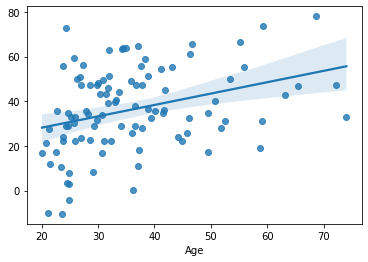

In [129]:
from sklearn.linear_model import LinearRegression
# cross validation
cv = KFold(5) # 5 folds, 20 participants in each fold

# names of the columns to be used
target = 'Age'
features = df.columns[2:]

# we will collect the predicted values here (initialize it with zeros)
cv_predictions = np.zeros(len(df))

for train_index, test_index in cv.split(df):
    # train on the actual training set
    model_2 = LinearRegression().fit(y=df.loc[train_index, target], X=df.loc[train_index, features])
    # test on the actual test set and collect it
    cv_predictions[test_index] = model_2.predict(df.loc[test_index, features])

# finally, plot cv_predictions vs. true age and calculate MAE
sns.regplot(x=df[target], y=cv_predictions)
print('MAE = ', np.mean(np.abs(df[target] - cv_predictions)), 'years')

In this example, in each cross-validation iteration, the size of the training set is 80, that is, equal to the size of the training set in the [previous section](train_test.ipynb).
Using this data only, i.e. without utilizing the previous section's test set, here we obtained unbiased estimates of predictive accuracy.

Comparably reliable estimates of the true predictive power with almost half the total sample size than in the previous section.
**That's the power of cross-validation!**

Of course, scikit-learn has shorthand functions for obtaining cross-validated predictions and performance scores.
This is illustrated here:

MAE =  15.12735493479741 years


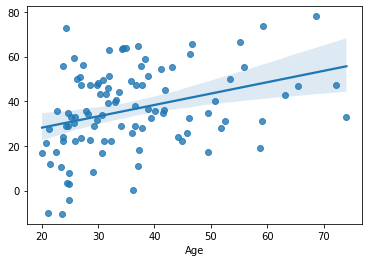

In [131]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error

cv_predictions = cross_val_predict(estimator=LinearRegression(), y=df[target], X=df[features], cv=KFold(5))
sns.regplot(x=df[target], y=cv_predictions)
print('MAE = ', mean_absolute_error(y_true=df[target], y_pred=cv_predictions), 'years')

This produces literally the same results, but is much shorter.


:::{admonition} Excercise 3.3
:class: tip, dropdown
Compare the MAE we got here to the MAE of model_2 on the training and test sets in the previous sections.
:::

:::{admonition} Excercise 3.4
:class: tip, dropdown
Try out other k-values for the KFold cross-validation and LOO with the same data?
Does it change the results? Can you explain the differences?
:::

:::{admonition} Excercise 3.5
:class: tip, dropdown
Load in more data, than try out different k-values again.
Is it still sensitive to k? Can you explain why/why not?
Tip: Understanding learning curves might help, see <todo: reference>.
:::

:::{admonition} Excercise 3.6
:class: tip, dropdown
Load in your own data and train a linear model with cross-validation.
:::

## Model Finalization

While cross-validation allows getting out the maximum of your dataset, as a result, you'll have to deal with a set of models, instead of one single model.
Although the cross-validation results may suggest that all of these models may be reasonably good, it might be still challenging to decide which one to present as the final model, for further use/validation.

Constructing the final model after cross-validation is called *model finalization*.

There are multiple strategies for model finalization. To mention a few, one can:
- simply pick one model from the cross-validation iterations (e.g randomly, or the best performing),
- average all models (model coefficients) from the cross-validation iterations,
- refit the model on the whole data and consider it as the final model.

:::{seealso}
You can read more about model finalization for instance [here](https://machinelearningmastery.com/train-final-machine-learning-model/)
:::

The last solution, i.e. refitting the model on the whole data, can be considered a good solution in many situations, especially with low/moderate sample sizes.

If the cross-validation was well designed, the performance measures will suitably describe how well the finalized model trained on all available historical data will perform in general.

What's more, if your model could - in general - benefit form more data (i.e. the learning curve is not yet saturating, see <todo> reference>), than you can hope that the finalized model (using all available data) will perform even better on brand new (e.g. prospectively acquired) than expected from the cross-validated predictions, as it was trained on more data than any of the cross-validation models.

Of course, in reality, generalization to newly measured data can be very problematic due to [dataset shift](https://gsarantitis.wordpress.com/2020/04/16/data-shift-in-machine-learning-what-is-it-and-how-to-detect-it/): changes in the data distribution, as compared to the training data.
Read more about dataset shift and related model validation issues in [chapter 6](../6_validity/index.md)

In this chapter, we have seen how testing on unseen data (with single splits or with cross-validation) can provide unbiased estimates of predictive models, even if the models overfitted on the truing data. In the [next section](../4_reducing_complexity/index.md) we will see how overfitting can be prevented by fine-tuning model complexity.